# An Introduction to Isolation Forests

This is an accompanying notebook for the package
[isotree](https://github.com/david-cortes/isotree)
presenting a short introduction to the Isolation Forest family of algorithms
as implemented in said package. For more information about it, see the GitHub page.
** *
## 1. Isolation Forests

## 1.1 Overview

Isolation Forest is an unsupervised decision-tree-based algorithm originally developed
for outlier detection in tabular data, which consists in splitting sub-samples of the data
according to some attribute/feature/column at random. The idea is that, the rarer the
observation, the more likely it is that a random split on some feature would put outliers alone
in one branch, and the fewer splits it will take to isolate (create a partition in which only
one point is present) an outlier observation like this.

The intuition behind it is very simple: if there is an outlier in the data and we pick a column
at random in which the value for the outlier point is different from the rest of the
observations, and then we select an arbitrary threshold uniformly at random within the range of
that column and divide all the points into two groups according to whether they are higher
or lower than the randomly-chosen threshold for that column, there is a higher chance that
the outlier point would end up in the smaller partition than in the larger partition.

Of course, outliers are typically not defined by just having one extreme value in one column,
and a good outlier detection method needs to look at the relationships between different
variables and their combinations. One potential way to do this is by building a so-called
"isolation tree", which consists of repeating the randomized splitting process described above
recursively (that is, we divide the points into two groups, then repeat the process in each
of the two groups that are obtained, and continue repeating it on the new groups until no
further split is possible or until meeting some other criteria).

Under this scheme, one can deduce that, the more common a point is, the more splits it will
take to leave the point alone or in a smaller group compared to uncommon points - as such,
one can think of the "isolation depth" (number of partitions that it takes to isolate a point,
hence the name of the algorithm) in the isolation trees as a metric by which to measure the
inlierness or outlierness of a point.

A single isolation tree has a lot of expected variability in the isolation depths that it is
expected to give to each observation, thus an ensemble of many such trees - an "isolation
forest" - may be used instead for better results, with the final score obtained by averaging
the results from many such trees.

There are many potential ways of improving upon the logic behind the procedure (for example,
extrapolating an isolation depth after reaching a certain limit) and the resulting score
can be standardized for easier usage, among many others - see the references for more details
about the methodology.

## 1.2 Why choose isolation forests over the alternatives

Compared to other outlier/anomaly detection methods such as "local outlier factor" or
"one-class support vector machines", isolation forests have advantages in that they are:

* Robust to the presence of outliers in training data.
* Robust to multi-modal distributions.
* Insensitive to the scales of variables.
* Much faster to fit.
* Invariant to the choice of distance metric (since it doesn't use a distance
metric in the first place).

Additionally, since they produce a standardized outlier metric for every point, such models
can be used for example to generate additional features for regression or classification models
or as a proxy for distribution density, for which not all outlier detection methods are
equally suitable (see the rest of the vignette for other potential uses of isolation forests).

## 1.3 An example in 1D

As a simple proof-of-concept test, one can think of producing random numbers from a normal
distribution and seeing what kinds of isolation depths would isolation trees assigning to
values from it:

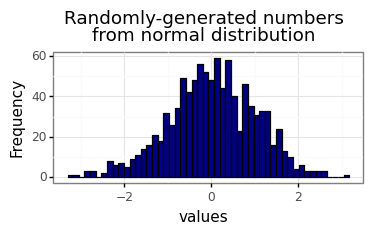

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import plotnine as p9

rng = np.random.default_rng(seed=123)
random_numbers = rng.standard_normal(size=1000)
plt = (
    p9.ggplot(pd.DataFrame({"values" : random_numbers}), p9.aes(x="values"))
    + p9.theme_bw()
    + p9.geom_histogram(color="black", fill="navy", bins=50)
    + p9.ylab("Frequency")
    + p9.ggtitle("Randomly-generated numbers\nfrom normal distribution")
    + p9.theme(figure_size=(4, 1.7))
)
print(plt)

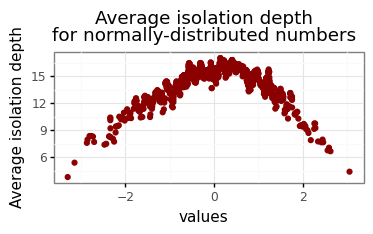

In [2]:
from isotree import IsolationForest

model = IsolationForest(ndim=1, ntrees=10).fit(random_numbers.reshape((-1,1)))
scores = model.predict(random_numbers.reshape((-1,1)), output="avg_depth")
plt = (
    p9.ggplot(
        pd.DataFrame({"values" : random_numbers, "score" : scores}),
        p9.aes(x="values", y="score")
    )
    + p9.theme_bw()
    + p9.geom_point(color="darkred")
    + p9.ylab("Average isolation depth")
    + p9.ggtitle("Average isolation depth\nfor normally-distributed numbers")
    + p9.theme(figure_size=(4, 1.7))
)
print(plt)

As expected, the isolation depth in this sample of randomly-generated numbers following
a normal distribution looks very similar to its probability distribution function, achieving
the goal of determining which kind of points are more common or less common compared to the
rest.

Of course, for simple 1D data, a kernel density estimate or similar would do a better job, but
once we start adding more dimensions to the data, something like a kernel density estimate
starts sounding less and less suitable, and more susceptible to the presence of outliers
(which is what we want to detect in the first place).

## 1.4 An example in 2D

The next example will now generate **standardized** outlier scores (see references for details
about this) for randomly-generated two-dimensional data.

In order to illustrate the advantages of isolation forests, this next example will generate
**two** clusters of normally-distributed numbers, and will add an outlier along the way
which could not be determined to be an outlier if looking at only one of the variables
in isolation.

For many other outlier/anomaly detection methods, having multi-modal distributions
like this is a big problem, and their performance suffers from contamination of the training
data with outliers. For isolation forests, these are not problematic:


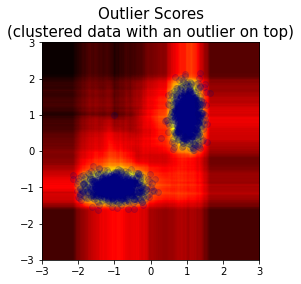

In [3]:
from  matplotlib import pyplot

### Randomly-generated data from different distributions
cluster1 = pd.DataFrame({
    "x" : rng.normal(-1, .4, size=1000),
    "y" : rng.normal(-1, .2, size=1000),
})
cluster2 = pd.DataFrame({
    "x" : rng.normal(+1, .2, size=1000),
    "y" : rng.normal(+1, .4, size=1000),
})
outlier = pd.DataFrame({
    "x" : [-1],
    "y" : [ 1],
})

### Putting them together
X = pd.concat([cluster1, cluster2, outlier], axis=0, ignore_index=True)

### Function to produce a heatmap of the scores
pts = np.linspace(-3, 3, 250)
space = np.array( np.meshgrid(pts, pts) ).reshape((2, -1)).T
space_index = pd.MultiIndex.from_arrays([space[:, 0], space[:, 1]])
def plot_space(Z, space_index, X):
    df = pd.DataFrame({"z" : Z}, index = space_index)
    df = df.unstack()
    df = df[df.columns.values[::-1]]
    pyplot.imshow(df, extent = [-3, 3, -3, 3], cmap = 'hot_r')
    pyplot.scatter(x = X['x'], y = X['y'], alpha = .15, c = 'navy')
    
model = IsolationForest(ndim=1, ntrees=100).fit(X)
scores = model.predict(space)
plot_space(scores, space_index, X)
pyplot.title(
    "Outlier Scores\n(clustered data with an outlier on top)",
    fontsize=15
)
pyplot.show()

** *
# 2. Variations of isolation forests

The isolation forest algorithm, as originally introduced in the paper "Isolation forest",
tends to provide reasonably good performance out-of-the-box across a variety of datasets and
problem domains, but it is far from universal or perfect: it suffers from many biases which
affect its performance, and there have been many sub-sequent papers trying to address some
of its issues by introducing changes in the splitting logic or in other aspects.

For example, in the plot above, it can be seen that it generated "ghost" regions of high
inlierness in areas parallel to the clusters along each axis, despite there not being any
data in those regions.

Enhanced variations of the algorithm have been proposed for example by introducing changes
in the logic as follows:

* Making splits with respect to a randomly-chosen hyperplane instead of making only
axis-parallel splits.
* Choosing the split point more carefully according to criteria related to standard deviations
or to density.
* Choosing the column more carefully according to other criteria (e.g. ranges, variances,
kurtosis, etc.).
* Changing the way in which outlier scores are calculated in order to look at more pieces
of information from the trees.

Here are some example variations on the same data as before:

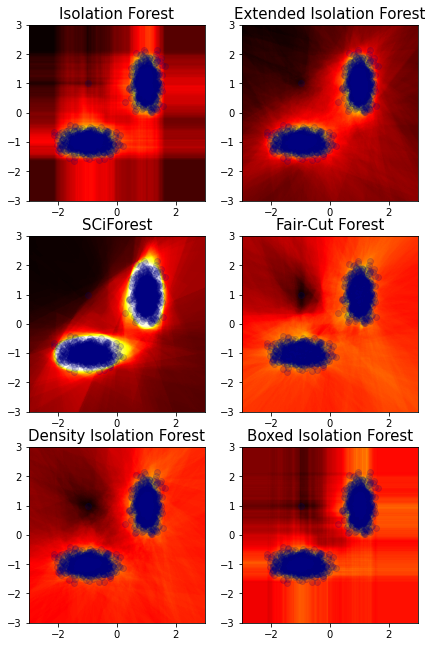

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 11

##########################
iforest = IsolationForest(
    ndim=1, ntrees=100,
    missing_action="fail"
).fit(X)
pyplot.subplot(3, 2, 1)
plot_space(
    iforest.predict(space),
    space_index,
    X
)
pyplot.title("Isolation Forest", fontsize=15)
##########################
ext_iforest = IsolationForest(
    ndim=2, ntrees=100,
    missing_action="fail"
).fit(X)
pyplot.subplot(3, 2, 2)
plot_space(
    ext_iforest.predict(space),
    space_index,
    X
)
pyplot.title("Extended Isolation Forest", fontsize=15)
##########################
sciforest = IsolationForest(
    ndim=2, ntrees=100,
    missing_action="fail",
    coefs="normal",
    prob_pick_avg_gain=1
).fit(X)
pyplot.subplot(3, 2, 3)
plot_space(
    sciforest.predict(space),
    space_index,
    X
)
pyplot.title("SCiForest", fontsize=15)
##########################
fcf = IsolationForest(
    ndim=2, ntrees=100,
    missing_action="fail",
    prob_pick_pooled_gain=1
).fit(X)
pyplot.subplot(3, 2, 4)
plot_space(
    fcf.predict(space),
    space_index,
    X
)
pyplot.title("Fair-Cut Forest", fontsize=15)
##########################
dens_iforest = IsolationForest(
    ndim=2, ntrees=100,
    missing_action="fail",
    scoring_metric="density"
).fit(X)
pyplot.subplot(3, 2, 5)
plot_space(
    dens_iforest.predict(space),
    space_index,
    X
)
pyplot.title("Density Isolation Forest", fontsize=15)
##########################
bdens_iforest = IsolationForest(
    ndim=1, ntrees=100,
    missing_action="fail",
    scoring_metric="density"
).fit(X)
pyplot.subplot(3, 2, 6)
plot_space(
    bdens_iforest.predict(space),
    space_index,
    X
)
pyplot.title("Boxed Isolation Forest", fontsize=15)
##########################
pyplot.show()

** *
# 3. An example with real data

Although the plots above can be illustrative for understanding what isolation forest and its
variants are doing, outlier detection in 1D and 2D data is an area in which many other
more successful methods have been tried and proved before. Where isolation forests does
shine though, is when the data has a larger number of dimensions, clustered outliers,
or multi-modal distributions.

One of the most common datasets for benchmarking outlier detection algorithms in more than
2 dimensions is the "Satellite" dataset, which was originally designed for multi-class
classification but is typically adapted for anomaly detection by merging the least common
classes together and labelling them as "anomalies" or "outliers".

From [ODDS](http://odds.cs.stonybrook.edu/satellite-dataset/):

> The original Statlog (Landsat Satellite) dataset from UCI machine learning repository is a
> multi-class classification dataset. Here, the training and test data are combined. The
> smallest three classes, i.e. 2, 4, 5 are combined to form the outliers class, while all
> the other classes are combined to form an inlier class. 

This makes it one of the hardest datasets for outlier detection, but the challenges it
introduces (clustered outliers, multi-modal distributions) are not an obstacle for
isolation forests.

The dataset with said conversion applied to it can be downloaded from ODDS at the link above. It comes in matlab format, which can be loaded through SciPy:

In [5]:
from scipy.io import loadmat

sat = loadmat("satellite.mat")
X = sat["X"]
y = sat["y"]
print("Dataset dimensions: (%d, %d)" % X.shape)
print("Percent anomalies: %.2f%%" % (100*y.mean()))

Dataset dimensions: (6435, 36)
Percent anomalies: 31.64%


Now the next chunk will fit different variants of isolation forests and assess how well they
do at discriminating outliers by calculating the AUROC (area under the ROC curve) that they
produce. Note that the models do not see any information about which observations are outliers
and which are not.

The original paper "Isolation Forest" suggested that models would converge with 100 trees, but
here it is possible to get slightly better performance by simply increasing the number of
trees and by bigger changes such as choosing a different scoring metric.

In [6]:
from sklearn.metrics import roc_auc_score

model_orig = IsolationForest(
    ndim=1, sample_size=256,
    ntrees=100,
    missing_action="fail"
)
pred_orig = model_orig.fit(X).predict(X)

model_dens = IsolationForest(
    ndim=1, sample_size=256,
    ntrees=100,
    missing_action="fail",
    scoring_metric="density"
)
pred_dens = model_dens.fit(X).predict(X)

model_fcf = IsolationForest(
    ndim=1, sample_size=32,
    prob_pick_pooled_gain=1,
    ntrees=100,
    missing_action="fail"
)
pred_fcf = model_fcf.fit(X).predict(X)

results_df = pd.DataFrame({
    "Model" : [
        "Isolation Forest",
        "Density Isolation Forets",
        "Fair-Cut Forest"
    ],
    "AUROC" : [
        roc_auc_score(y, pred_orig),
        roc_auc_score(y, pred_dens),
        roc_auc_score(y, pred_fcf),
    ]
})
results_df

,Model,AUROC
0,Isolation Forest,0.691022
1,Density Isolation Forets,0.826593
2,Fair-Cut Forest,0.896931


For comparison purposes, what follows next (one-class SVM) is one of the most widely-used
methods for outlier detection other than isolation forest - as will be seen,
"one-class support vector machines" are not very suitable to this kind of data,
and even if it were to be tuned, its performance would not match that of isolation forest variants:

In [7]:
from sklearn.svm import OneClassSVM

model_svm = OneClassSVM(kernel="sigmoid",  gamma="scale")
pred_svm = model_svm.fit(X).decision_function(X)
results_svm = pd.DataFrame({
    "Model" : ["One-Class SVM"],
    "AUROC" : [roc_auc_score(y, -pred_svm)]
})
results_svm

,Model,AUROC
0,One-Class SVM,0.686582


_(Note that scikit-learn's objects output scores in the opposite direction: for them, higher scores means more inlinerness, while for `isotree`, higher scores means more outlierness)_
** *
# 4. Other uses for isolation trees

The scores obtained from isolation forest models can also be used as a proxy for density
or as an additional feature in regression and classification tasks, which can be particularly
helpful for domains like fraud detection, and can be used as a hint for determining whether
there has been any covariate drift in a dataset (as part of other methods). When used for
purposes other than anomaly detection, it is recommended to fit trees beyond balanced-tree
height limit (see documentation for details).

Apart from the outlier scores, the package `isotree` can also do the following:

* Calculate distances between pairs of points based on how many splits it takes to separate
them, resulting in a standardized and centered metric just like for the outlier scores.
This distance can be used for example for clustering, as an SVM kernel, as extra features, etc.
* Impute missing values by taking the points in each terminal node as near neighbors and
generating an average from them or from those of the nearest parent node if necessary.
* Produce a "proximity matrix" or "isolation kernel" that tells for every pair of points
in what percentage of the trees did they end up sharing the same terminal node - for example,
this can be used as a rough estimate of residual covariances in generalized least squares,
and some authors report success using it as an SVM kernel (it's recommended to use the
distance metric instead as it's better quality though).
* Output the raw terminal node numbers or per-tree depths in order to use them for something
else - for example, can be used as a cheap clustering with overlapping assigments across trees.

# 5. References

* Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. "Isolation forest." 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.
* Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. "Isolation-based anomaly detection." ACM Transactions on Knowledge Discovery from Data (TKDD) 6.1 (2012): 3.
* Hariri, Sahand, Matias Carrasco Kind, and Robert J. Brunner. "Extended Isolation Forest." arXiv preprint arXiv:1811.02141 (2018).
* Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. "On detecting clustered anomalies using SCiForest." Joint European Conference on Machine Learning and Knowledge Discovery in Databases. Springer, Berlin, Heidelberg, 2010.
* https://sourceforge.net/projects/iforest/
* https://math.stackexchange.com/questions/3388518/expected-number-of-paths-required-to-separate-elements-in-a-binary-tree
* Quinlan, J. Ross. C4. 5: programs for machine learning. Elsevier, 2014.
* Cortes, David. "Distance approximation using Isolation Forests." arXiv preprint arXiv:1910.12362 (2019).
* Cortes, David. "Imputing missing values with unsupervised random trees." arXiv preprint arXiv:1911.06646 (2019).
* Cortes, David. "Revisiting randomized choices in isolation forests." arXiv preprint arXiv:2110.13402 (2021).
* Guha, Sudipto, et al. "Robust random cut forest based anomaly detection on streams." International conference on machine learning. PMLR, 2016.
* Cortes, David. "Isolation forests: looking beyond tree depth." arXiv preprint arXiv:2111.11639 (2021).
* Ting, Kai Ming, Yue Zhu, and Zhi-Hua Zhou. "Isolation kernel and its effect on SVM." Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. 2018.